## Constructing Circuits from other Circuits 

A common pattern that is used extensively in `Magma` is to write general
functions that construct new circuits from other circuits.
This circuit constructors are analogous to the higher-order functions
in a functional programming languages.
Examples in functional programming languages include `map` and `fold`.
The corresponding `Magma` operators are `join`, `fork`, `fold`, and `scan`.
`Magma` generalizes these functions with `braid`,
that allows one to construct systolic arrays which
cannot be described using functions since they wire stateful elements.

In [1]:
import magma as m
m.set_mantle_target("ice40")

## Register - `col` and `join`

Perhaps the simplest example is the `Mantle` function that constructs a n-bit `Register`.

To do this we use the `Magma` `col` and `join` functions. 
`col` takes a `Circuit` constructor and the number `n` of circuit instances to create.
It returns a list of circuit instances.
`join` combines `n` circuit instances together into a single circuit.

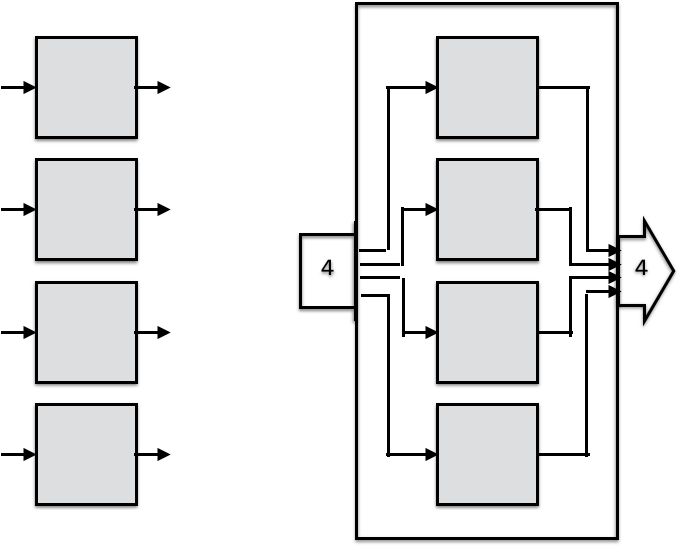

In [2]:
from mantle import DFF

def DefineRegister(n):
    """
    Generate an n-bit register

    Interface
    ---------
        I : In(Bits(n)), O : Out(Bits(n))
    """
    T = m.Bits(n)
    class _Register(Circuit):
        name = f'Register{n}'
        IO  = ['I', m.In(T), 'O', m.Out(T)] + m.ClockInterface()
        @classmethod
        def definition(io):
            reg = m.join(m.col(DFF, n))
            m.wire(reg(io.I), io.O)
    return _Register

import lattice ice40
import lattice mantle40


## fork

`fork(list)` creates a single circuit from a list of instances.
Just as with join, the outputs of the circuits are concatenated together to form a array.
However, the inputs are not concatenated, they are forked.
That is, all the inputs are wired together.

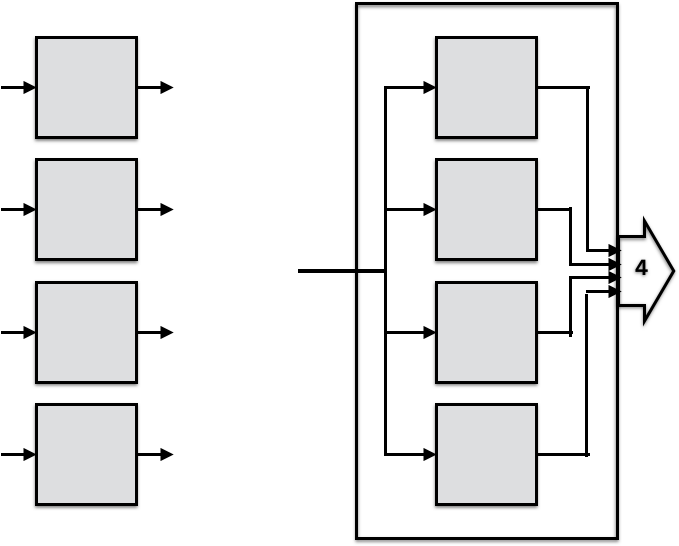

from mantle import LUT4

def DefineROM4(n, data):
    class _ROM(Circuit):
        name = f'ROM{n}x4'
        IO = ['RADDR', In(m.Bits(n)), 'RDATA', m.Out(m.Bits(4))]
        @classmethod
        def definition(io):
            def f(y):
                return m.uncurry(LUT4(data[y]))
            rom = m.fork( m.col(f, n) )
            m.wire( rom( io.RADDR ), io.RDATA )
    return _ROM

There is a lot going on in this function. First, note that we use the `Magma`
operator `uncurry` to convert the inputs of the LUT to an array of 4 bits.
LUT4s have 4 separate inputs by default. 

Another subtlety in this code is the function `f`. When invoking `col`
the position of the created instance is passed to the circuit construction procedure.
We use this position to initialize each LUT to a different element of the `data` array.

The list of `n` `ROM4` instances are then passed to `fork`.
`fork` wires the same address lines to each `ROM4`.

## fold

`fold` is a classic higher-order function.
The `Magma` fold takes a list of circuit,
and wires the output of one circuit to the input of another circuit.
The input of the first circuit instance becomes the input of the final circuit,
and the output of the last instance becauses the output.
The rest of the inputs and outputs are joined.

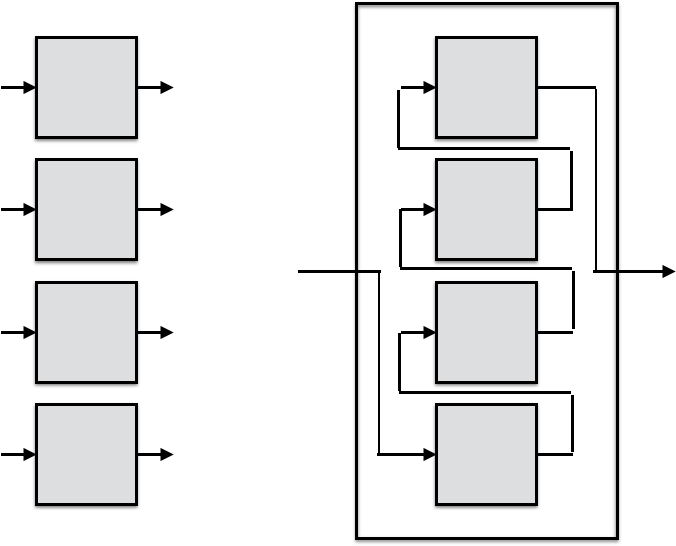

The convention is that the output `O` will be wired to the input `I`.

A good example of this in action is to combine `n` DFFs into a serial-in serial-out (SISO)
shift register.
The output of each DFF is connected to the input of the next DFF.

In [3]:
# The Mantle function `FFs` returns a list of `n` DFFs.
from mantle import FFs

def DefineSISO(n):
    """
    Generate Serial-In, Serial-Out shift register.

    I : In(Bit), O : Out(Bit)
    """
    class _SISO(m.Circuit):
        name = f'SISO{n}'
        IO = ['I', m.In(m.Bit), 'O', m.Out(m.Bit)] + m.ClockInterface()
        @classmethod
        def definition(io):
            reg = m.fold(FFs(n))
            m.wire(reg(siso.I), siso.O)
    return _SISO

## scan

`fold` is a classic higher-order function.
The `Magma` fold takes a list of circuit,
and wires the output of one circuit to the input of another circuit.
The input of the first circuit instance becomes the input of the final circuit,
and the output of the last instance becauses the output.
The rest of the inputs and outputs are joined.

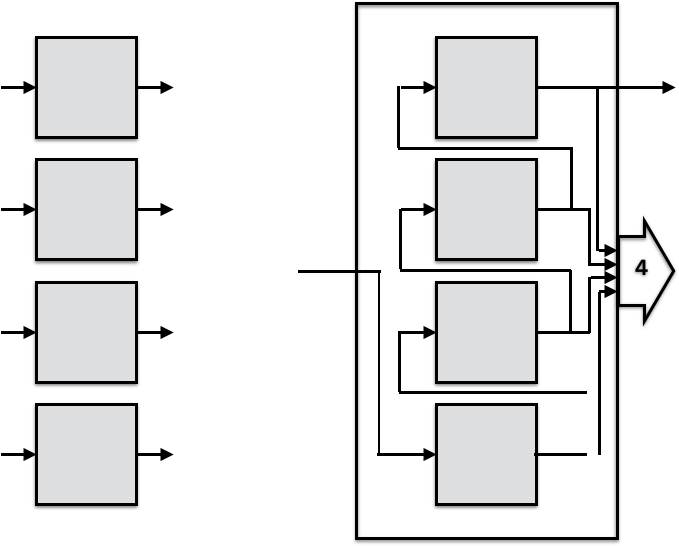

The convention is that the output `O` will be wired to the input `I`.

`scan` can be used to combine `n` DFFs into a serial-in parallel-out (SIPO)
shift register.
The output of each DFF is connected to the input of the next DFF.
In addition, all the outputs are joined to form an array of bits.

In [4]:
def DefineSIPO(n):
    """
    Generate Serial-In, Parallel-Out shift register.

    I : In(Bit), O : Out(Bits(n))
    """
    T = m.Bits(n)
    class _SIPO(Circuit):
        name = f'SIPO{n}'
        IO = ['I', m.In(m.Bit), 'O', m.Out(m.Bit)] + m.ClockInterface()
        @classmethod
        def definition(io):
            reg = m.scan(FFs(n))
            m.wire(reg(siso.I), siso.O)
    return _SISO

## braid

These high-order circuit construction operators 
can be precisely constrolled using `braid`.
`braid` can be used to construct general systolic circuits.

Braid takes a list of circuit instances as an input,
and simultaenously wires up the various inputs and outputs
in the desired way.
The advantage of braid is that inputs and outputs can be selected by name,
and different methods can be used to wire up inputs and outputs.
```
def braid(circuits,
  joinargs=[],
  flatargs=[],
  forkargs=['RESET','SET','CE','CLK'],
  foldargs={}, rfoldargs={},
  scanargs={}, rscanargs={}):
```
Note that by default, the clock signals are forked.

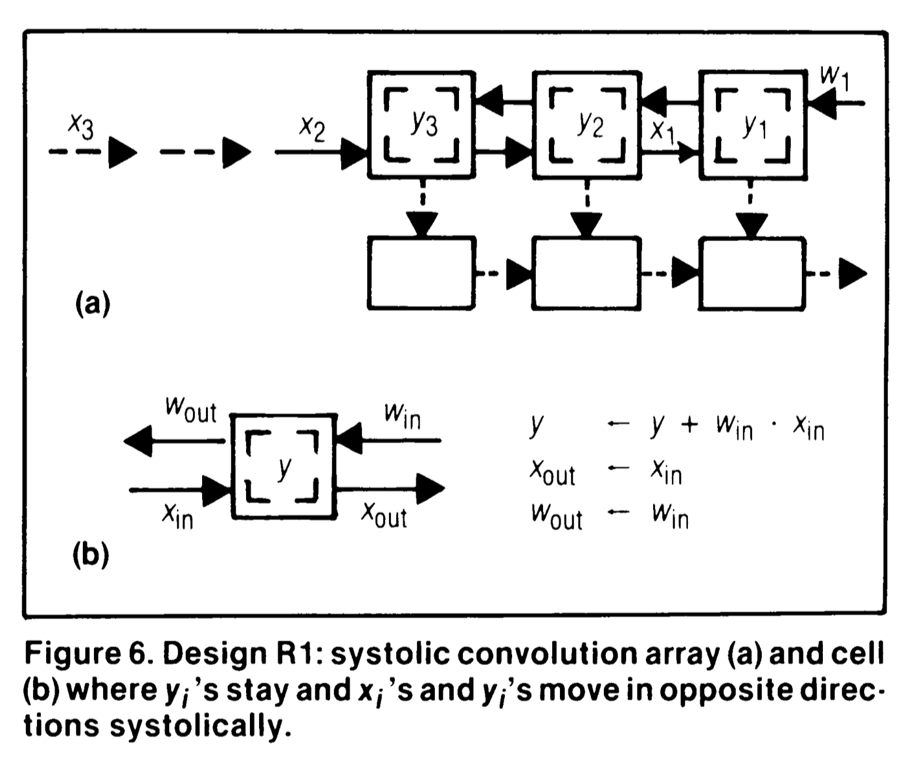

Figure from Kung and Leiserson.

For example,
```
braid(circuits, foldargs={'I': 'O'})
```
is equivalent to fork.

Similarly, for `scan`
```
braid(circuits, scanargs={'I': 'O'})
```
If you want to do a scan in a different direction, use
```
braid(circuits, rscanargs={'I': 'O'})
```
`rscanargs`, for right-scan.